In [ ]:
import pandas as pd
import numpy as np
import plotly.io as pio
pio.renderers.default = "notebook_connected"
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix

<h1> Functions <h1>

In [ ]:
#logistic regression with RFE
def RFE_logistic(dataframe, y, n_features):
    logreg = LogisticRegression()
    y = y.astype(int)
    
    rfe = RFE(logreg, n_features_to_select=n_features)
    rfe = rfe.fit(dataframe, y)
    print(rfe.support_)
    print(rfe.ranking_)

In [ ]:
def fit_logistic (dataframe, y):
    X_train, X_test, y_train, y_test = train_test_split(dataframe, y, test_size = 0.3)
    y_train = y_train.astype(int)

    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    
    y_pred = logreg.predict(X_test)
    print('Accuracy on test set: {:.2f}'.format (logreg.score(X_test, y_test)))
    plot_confusion_matrix(logreg, X_test, y_test)
    print(classification_report(y_test, y_pred))

In [ ]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

<h1> Loading dataset and EDA <h1>

In [ ]:
 df = pd.read_csv("/Users/dominik/Desktop/breast-cancer.csv")  
 df.head()

In [ ]:
df.dtypes


In [ ]:
df.describe()

In [ ]:
del df['id']

In [ ]:
df['diagnosis'].value_counts()

**we can see that whe have enough "malignant" labels, so we don't have to worry about not sufficient amount of the true labels**

In [ ]:
df.loc[df['diagnosis'] == 'M', 'diagnosis'] = 1
df.loc[df['diagnosis'] == 'B', 'diagnosis'] = 0

In [ ]:
df.head()

In [ ]:
df.isna().sum()

In [ ]:
columns = df.columns[1:]

In [ ]:
for col in df.columns[1:]:
    
    fig = px.histogram(df[col], nbins = 60)
    fig.update_layout(bargap=0)
    fig.show()

In [ ]:
df_corr = df.corr()

fig = go.Figure()
fig.add_trace(
    go.Heatmap(
    z=np.array(df_corr),
    x=df_corr.index ,
    y=df_corr.columns,
    colorscale=px.colors.diverging.RdBu,
    zmin=-1,
    zmax=1
    )
)
fig.show()


In [ ]:
df.groupby('diagnosis').mean()

**This gives us a really clear view on which variables can matter while building a classification algorithm. For example, area_mean or concavity_mean seem to be really important, whereas fractal_dimension_mean or symmetry_mean have similar values for both labels**

In [ ]:
plot_data = df.iloc[:, 1:]


for col in df.columns[1:]:

    fig = px.histogram(
    df,
    x = "diagnosis",
    y = col,
    color = "diagnosis",
    histfunc = "avg"
    )
    fig.show()

**I've decided to create a classification model based on parameters describing mean values**

In [ ]:
df_model = [df[col] for col in df.columns if 'mean' in col]
df_model = pd.DataFrame(df_model).T
y = df['diagnosis']
df_model.head()

<h1> Configurating classification algorithms <h1>

<h2> I will try to fit 3 logistic regression models: <h2>
<h3>
1. Model with all variables from df_model dataframe <br>
2. 2 RFE models, which builds multiple models and checks if adding an additional variables makes the model better (will select 6 and 8 features) 
<h3>


In [ ]:
smlog = sm.Logit(y, sm.add_constant(df_model))
results = smlog.fit()
print(results.summary2())

In [ ]:
probability = 1 / (1 + np.exp(-results.fittedvalues))
px.histogram(probability)

In [ ]:
fit_logistic(df_model, y)

**Second model (RFE with 8 features)**

In [ ]:
df_model2 = df_model.copy()

In [ ]:
RFE_logistic(df_model2, y, 8)

In [ ]:
df_model2 = df_model2.drop(['area_mean', 'fractal_dimension_mean'], axis = 1)

In [ ]:
smlog = sm.Logit(y, sm.add_constant(df_model2))
results = smlog.fit()
print(results.summary2())

In [ ]:
probability = 1 / (1 + np.exp(-results.fittedvalues))
px.histogram(probability)

In [ ]:
fit_logistic(df_model2, y)

**Third model: RFE Logistic with 5 features**

In [ ]:
df_model3 = df_model.copy()

In [ ]:
RFE_logistic(df_model3, y, 5)

In [ ]:
df_model3 = df_model3.drop(['texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'fractal_dimension_mean'], axis = 1)

In [ ]:
smlog_3 = sm.Logit(y, sm.add_constant(df_model3))
results = smlog_3.fit()
print(results.summary2())

In [ ]:
probability = 1 / (1 + np.exp(-results.fittedvalues))
px.histogram(probability)

Accuracy on test set: 0.91
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       117
           1       0.84      0.87      0.85        54

    accuracy                           0.91       171
   macro avg       0.89      0.90      0.89       171
weighted avg       0.91      0.91      0.91       171



/Users/dominik/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



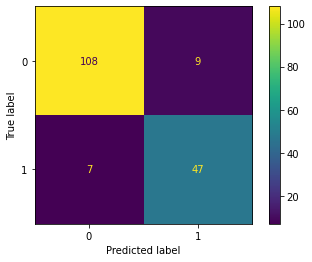

In [211]:
fit_logistic(df_model3, y)